<a href="https://colab.research.google.com/gist/klarteno/0eee61b980f8feca34c731338f03b5b7/copy-of-aml-final-project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##### use the .py version of this for import in notebooks


In [1]:
import torch
import numpy as np
import pandas as pd
import sys
import os

import glob
from torchvision.transforms import ToTensor

import matplotlib.pyplot as plt

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset,DataLoader

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder #, OneHotEncoder

from pprint import pprint
import time



In [2]:
'''
from google.colab import drive
drive.mount('/content/drive', force_remount=True)
%cd '/content/drive/My Drive/1_MalmoUni/AdvML/Project'
'''

"\nfrom google.colab import drive\ndrive.mount('/content/drive', force_remount=True)\n%cd '/content/drive/My Drive/1_MalmoUni/AdvML/Project'\n"

# CICIDS2017 dataset
------------------------------------------------

<div>
    <b>Dataset description</b>: The CICIDS2017 dataset, which has been created by the <a href="https://www.unb.ca/cic/datasets/ids-2017.html">Canadian Institute for Cyber-security (CIC)</a>, consists of labeled network flows. The CICIDS2017 contains benign and the most up-to-date common attacks. It is made up of 2,830,743 records with a total of 78 features.
</div>

In [3]:
def clean_column_name(column):
    column = column.strip(' ')
    column = column.replace('/', '_')
    column = column.replace(' ', '_')
    column = column.lower()
    return column

In [4]:
# DATA_DIR  = os.path.join(os.path.abspath("."), "datasets\MachineLearningCSV\MachineLearningCVE")
DATA_DIR  = os.path.join(os.path.abspath("."), "datasets/MachineLearningCSV/MachineLearningCVE")


# Read all the .csv files
filenames = glob.glob(os.path.join(DATA_DIR,  '*.csv'))
datasets = [pd.read_csv(filename) for filename in filenames]

# Remove white spaces and rename the columns
for dataset in datasets:
    dataset.columns = [clean_column_name(column) for column in dataset.columns]

# Concatenate the datasets
dataset = pd.concat(datasets, axis=0, ignore_index=True)
#dataset.drop(labels=['fwd_header_length.1'], axis= 1, inplace=True)

In [5]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2830743 entries, 0 to 2830742
Data columns (total 79 columns):
 #   Column                       Dtype  
---  ------                       -----  
 0   destination_port             int64  
 1   flow_duration                int64  
 2   total_fwd_packets            int64  
 3   total_backward_packets       int64  
 4   total_length_of_fwd_packets  int64  
 5   total_length_of_bwd_packets  int64  
 6   fwd_packet_length_max        int64  
 7   fwd_packet_length_min        int64  
 8   fwd_packet_length_mean       float64
 9   fwd_packet_length_std        float64
 10  bwd_packet_length_max        int64  
 11  bwd_packet_length_min        int64  
 12  bwd_packet_length_mean       float64
 13  bwd_packet_length_std        float64
 14  flow_bytes_s                 float64
 15  flow_packets_s               float64
 16  flow_iat_mean                float64
 17  flow_iat_std                 float64
 18  flow_iat_max                 int64  
 19  

In [6]:
dataset.head(5)

,destination_port,flow_duration,total_fwd_packets,total_backward_packets,total_length_of_fwd_packets,total_length_of_bwd_packets,fwd_packet_length_max,fwd_packet_length_min,fwd_packet_length_mean,fwd_packet_length_std,...,min_seg_size_forward,active_mean,active_std,active_max,active_min,idle_mean,idle_std,idle_max,idle_min,label
0,54865,3,2,0,12,0,6,6,6.0,0.0,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
1,55054,109,1,1,6,6,6,6,6.0,0.0,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
2,55055,52,1,1,6,6,6,6,6.0,0.0,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
3,46236,34,1,1,6,6,6,6,6.0,0.0,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
4,54863,3,2,0,12,0,6,6,6.0,0.0,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN


In [7]:
dataset.label.value_counts()

BENIGN                        2273097
DoS Hulk                       231073
PortScan                       158930
DDoS                           128027
DoS GoldenEye                   10293
FTP-Patator                      7938
SSH-Patator                      5897
DoS slowloris                    5796
DoS Slowhttptest                 5499
Bot                              1966
Web Attack � Brute Force         1507
Web Attack � XSS                  652
Infiltration                       36
Web Attack � Sql Injection         21
Heartbleed                         11
Name: label, dtype: int64

In [ ]:
(65/100)*2273097

In [8]:
dataset.duplicated(keep=False).sum()

403550

In [9]:
print('Datase duplicates :', dataset.duplicated().any())
lenght_data = len(dataset)
dataset.drop_duplicates(inplace=True, keep=False, ignore_index=True)
# Remove duplicate rows
dups_count = lenght_data-len(dataset)

print('count of duplicate values dropped: ', dups_count)

Datase duplicates : True
count of duplicate values dropped:  403550


Check and drop if there are missing values in each feature.
All the missing values come from the `flow_bytes_s`.

In [10]:
def print_nans():
    result = dataset.isna().sum()
    
    for idx in result.index:
        if result[idx] > 0:
            print(idx,' has NAN values :' ,result[idx])      

print_nans()  

lenght_data = len(dataset)
dataset.dropna(axis=0, inplace=True, how="any")
# Remove duplicate rows
dups_count = lenght_data-len(dataset)

print('count of NANs values dropped: ', dups_count)

flow_bytes_s  has NAN values : 334
count of NANs values dropped:  334


Checking if all values are finite.

In [11]:
print('are all values finite: ',np.all(np.isfinite(dataset.drop(['label'], axis=1))))
# Replace infinite values to NaN
dataset.replace([-np.inf, np.inf], np.nan, inplace=True)
print_nans()  

are all values finite:  False
flow_bytes_s  has NAN values : 1132
flow_packets_s  has NAN values : 1132


Check which labels are related to infinte values  <br/>
BENIGN labels are the majority and have the highest count of infinte values  <br/>
The number of infinte values are small comparative with the number of values for each label  <br/>

In [12]:
dataset[(dataset['flow_bytes_s'].isna()) & (dataset['flow_packets_s'].isna())].label.value_counts()

BENIGN         1001
PortScan        124
Bot               4
DDoS              2
FTP-Patator       1
Name: label, dtype: int64

In [13]:
lenght_data = len(dataset)

# Remove infinte values
dataset.dropna(axis=0, how='any', inplace=True)

dups_count = lenght_data-len(dataset)

print('count of infinte values dropped: ', dups_count)

count of infinte values dropped:  1132


## Outliers
There are outliers but is assummed the neural networks will handle it for the moment

In [14]:
Q1 = dataset.quantile(0.25)
Q3 = dataset.quantile(0.75)
IQR = Q3 - Q1

# Identifying outliers with interquartile range
filt = (dataset < (Q1 - 1.5 * IQR)) | (dataset > (Q3 + 1.5 * IQR))
print(filt.sum())

ack_flag_count                      0
act_data_pkt_fwd               193207
active_max                     558821
active_mean                    558821
active_min                     558821
                                ...  
total_backward_packets         239223
total_fwd_packets              252467
total_length_of_bwd_packets    492852
total_length_of_fwd_packets    309634
urg_flag_count                 252178
Length: 79, dtype: int64


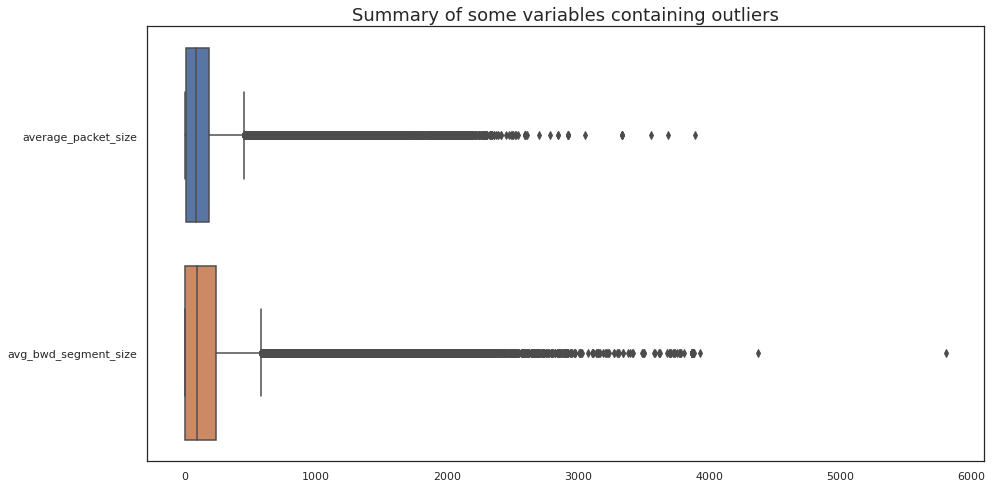

In [15]:
import seaborn as sns
sns.set_theme(style="white", color_codes=True)

fig = plt.figure(figsize=(15, 8))
sns.boxplot(data=dataset[["average_packet_size", "avg_bwd_segment_size"]], orient="h")

plt.title('Summary of some variables containing outliers', fontsize=18)
plt.show()


In [16]:
dataset_datatypes = dataset.columns.to_series().groupby(dataset.dtypes).groups
datatypes_info = {k.name: v for k, v in dataset_datatypes.items()}

pprint(datatypes_info)
pprint(dataset.describe(include=[object]).transpose())

{'float64': Index(['fwd_packet_length_mean', 'fwd_packet_length_std',
       'bwd_packet_length_mean', 'bwd_packet_length_std', 'flow_bytes_s',
       'flow_packets_s', 'flow_iat_mean', 'flow_iat_std', 'fwd_iat_mean',
       'fwd_iat_std', 'bwd_iat_mean', 'bwd_iat_std', 'fwd_packets_s',
       'bwd_packets_s', 'packet_length_mean', 'packet_length_std',
       'packet_length_variance', 'average_packet_size', 'avg_fwd_segment_size',
       'avg_bwd_segment_size', 'active_mean', 'active_std', 'idle_mean',
       'idle_std'],
      dtype='object'),
 'int64': Index(['destination_port', 'flow_duration', 'total_fwd_packets',
       'total_backward_packets', 'total_length_of_fwd_packets',
       'total_length_of_bwd_packets', 'fwd_packet_length_max',
       'fwd_packet_length_min', 'bwd_packet_length_max',
       'bwd_packet_length_min', 'flow_iat_max', 'flow_iat_min',
       'fwd_iat_total', 'fwd_iat_max', 'fwd_iat_min', 'bwd_iat_total',
       'bwd_iat_max', 'bwd_iat_min', 'fwd_psh_flags', '

In [17]:
dataset[['flow_bytes_s', 'flow_packets_s']] = dataset[['flow_bytes_s', 'flow_packets_s']].apply(pd.to_numeric)

## Inputs-Output Data Split

In [18]:
Y = dataset.label
X = dataset.drop(columns='label')

class_labels = Y.unique()

num_classes = Y.nunique()     # number of unique values
print("shape of X: ",X.shape)
print("number of labels of y: ", num_classes)
print("Class labels: ", class_labels)

shape of X:  (2425727, 78)
number of labels of y:  15
Class labels:  ['BENIGN' 'DDoS' 'PortScan' 'Bot' 'Infiltration'
 'Web Attack � Brute Force' 'Web Attack � XSS'
 'Web Attack � Sql Injection' 'FTP-Patator' 'SSH-Patator' 'DoS slowloris'
 'DoS Slowhttptest' 'DoS Hulk' 'DoS GoldenEye' 'Heartbleed']


In [19]:
#  are there missing values
'''

from sklearn.impute import SimpleImputer

mean_imp = SimpleImputer(missing_values=-1, strategy='mean')
cat_imp = SimpleImputer(missing_values=-1, strategy='most_frequent')
for c in X.columns:
  X[c] = mean_imp.fit_transform(X[[c]]).ravel()
  
'''


"\n\nfrom sklearn.impute import SimpleImputer\n\nmean_imp = SimpleImputer(missing_values=-1, strategy='mean')\ncat_imp = SimpleImputer(missing_values=-1, strategy='most_frequent')\nfor c in X.columns:\n  X[c] = mean_imp.fit_transform(X[[c]]).ravel()\n  \n"

In [20]:
X.columns

Index(['destination_port', 'flow_duration', 'total_fwd_packets',
       'total_backward_packets', 'total_length_of_fwd_packets',
       'total_length_of_bwd_packets', 'fwd_packet_length_max',
       'fwd_packet_length_min', 'fwd_packet_length_mean',
       'fwd_packet_length_std', 'bwd_packet_length_max',
       'bwd_packet_length_min', 'bwd_packet_length_mean',
       'bwd_packet_length_std', 'flow_bytes_s', 'flow_packets_s',
       'flow_iat_mean', 'flow_iat_std', 'flow_iat_max', 'flow_iat_min',
       'fwd_iat_total', 'fwd_iat_mean', 'fwd_iat_std', 'fwd_iat_max',
       'fwd_iat_min', 'bwd_iat_total', 'bwd_iat_mean', 'bwd_iat_std',
       'bwd_iat_max', 'bwd_iat_min', 'fwd_psh_flags', 'bwd_psh_flags',
       'fwd_urg_flags', 'bwd_urg_flags', 'fwd_header_length',
       'bwd_header_length', 'fwd_packets_s', 'bwd_packets_s',
       'min_packet_length', 'max_packet_length', 'packet_length_mean',
       'packet_length_std', 'packet_length_variance', 'fin_flag_count',
       'syn_flag_co

##### Select the number of relevant features out of total of 78

In [21]:
X_select_78_features = X

selected_features = ["bwd_packet_length_min", "subflow_fwd_bytes", "total_length_of_fwd_packets", "fwd_packet_length_mean", "bwd_packet_length_std", "flow_iat_min", "fwd_iat_min", "flow_iat_mean", "flow_duration", "flow_iat_std", "init_win_bytes_forward", "active_min", "active_mean", "bwd_packets_s", "bwd_iat_mean", "fwd_iat_mean", "ack_flag_count", "fwd_psh_flags", "syn_flag_count", "fwd_packets_s", "init_win_bytes_backward", "psh_flag_count", "average_packet_size"]
X_select_23_features = X[np.intersect1d(X.columns, selected_features)]

print('X_select_78_features', X_select_78_features.shape)
print('X_select_23_features', X_select_23_features.shape)

X_select_78_features (2425727, 78)
X_select_23_features (2425727, 23)


In [22]:
X_train_78_features, X_test_78_features, Y_train, Y_test = train_test_split(X_select_78_features, Y, random_state=42, stratify=Y)
X_train_23_features, X_test_23_features, Y_train, Y_test = train_test_split(X_select_23_features, Y, random_state=42, stratify=Y)


print("\nafter spliting the data:")
print("x training data shape:", X_train_78_features.shape)
print("x test data shape:", X_test_78_features.shape)

print("x training data shape:", X_train_23_features.shape)
print("x test data shape:", X_test_23_features.shape)

print("y training data shape:", Y_train.shape)
print("y test data shape:", Y_test.shape)



after spliting the data:
x training data shape: (1819295, 78)
x test data shape: (606432, 78)
x training data shape: (1819295, 23)
x test data shape: (606432, 23)
y training data shape: (1819295,)
y test data shape: (606432,)


##### Encode the text of the labels to numbers

In [23]:
le = LabelEncoder()       # Encode target labels with value between 0 and n_classes-1

Y_train_binary = le.fit_transform(Y_train)

#print("instances per label in test set\n", y_test_binary.value_counts())
# transform -	Transform labels to normalized encoding.
Y_test_binary = le.transform(Y_test)

#we use fit_transform() on training data but transform() on the test data

# classes_ - ndarray of shape (n_classes,) - Holds the label for each class.
# To create a dictionary from two sequences, use dict(zip(keys, values))
# The zip(fields, values) method returns an iterator that generates two-items tuples 
labels_dict = dict(zip(le.classes_, range(len(le.classes_))))

pprint(labels_dict)




import pickle

_file = open("datasets/labels_dict_file.pkl","wb")
pickle.dump(labels_dict, _file)
_file.close()

{'BENIGN': 0,
 'Bot': 1,
 'DDoS': 2,
 'DoS GoldenEye': 3,
 'DoS Hulk': 4,
 'DoS Slowhttptest': 5,
 'DoS slowloris': 6,
 'FTP-Patator': 7,
 'Heartbleed': 8,
 'Infiltration': 9,
 'PortScan': 10,
 'SSH-Patator': 11,
 'Web Attack � Brute Force': 12,
 'Web Attack � Sql Injection': 13,
 'Web Attack � XSS': 14}


In [24]:
!pwd

/mnt/batch/tasks/shared/LS_root/mounts/clusters/mycomputenotebook1/code/Users/bredsoby


##### Sample only trainning data an leave the test or validation data as is  </br>
 run the code in the cell only if saved sampled data is missing

In [25]:
# from imblearn.under_sampling import InstanceHardnessThreshold


'''
iht = InstanceHardnessThreshold(random_state=42, sampling_strategy='majority', n_jobs=os.cpu_count())

X_train_78_features_sampled, Y_train_78_features_sampled = iht.fit_resample(X_train_78_features, Y_train_binary)

# save what have been sampled to files 
X_train_78_features_sampled.to_csv('datasets/X_train_78_features_sampled.csv')
np.savetxt("datasets/y_train_binary_78_features_sampled.csv", Y_train_78_features_sampled, delimiter=",")
X_train_78_features_sampled = None
Y_train_78_features_sampled = None


X_train_23_features_sampled, Y_train_23_features_sampled = iht.fit_resample(X_train_23_features, Y_train_binary)

# save what have been sampled to files
X_train_23_features_sampled.to_csv('datasets/X_train_23_features_sampled.csv')
np.savetxt("datasets/y_train_binary_23_features_sampled.csv", Y_train_23_features_sampled, delimiter=",")


X_test_78_features.to_csv('datasets/X_test_78_features.csv')
X_test_23_features.to_csv('datasets/X_test_23_features.csv')

np.savetxt("datasets/y_test_binary.csv", Y_test_binary, delimiter=",")
'''


'\niht = InstanceHardnessThreshold(random_state=42, sampling_strategy=\'majority\', n_jobs=os.cpu_count())\n\nX_train_78_features_sampled, Y_train_78_features_sampled = iht.fit_resample(X_train_78_features, Y_train_binary)\n\n# save what have been sampled to files \nX_train_78_features_sampled.to_csv(\'datasets/X_train_78_features_sampled.csv\')\nnp.savetxt("datasets/y_train_binary_78_features_sampled.csv", Y_train_78_features_sampled, delimiter=",")\nX_train_78_features_sampled = None\nY_train_78_features_sampled = None\n\n\nX_train_23_features_sampled, Y_train_23_features_sampled = iht.fit_resample(X_train_23_features, Y_train_binary)\n\n# save what have been sampled to files\nX_train_23_features_sampled.to_csv(\'datasets/X_train_23_features_sampled.csv\')\nnp.savetxt("datasets/y_train_binary_23_features_sampled.csv", Y_train_23_features_sampled, delimiter=",")\n\n\nX_test_78_features.to_csv(\'datasets/X_test_78_features.csv\')\nX_test_23_features.to_csv(\'datasets/X_test_23_features

In [26]:
'''
# zip the generated files
from zipfile import ZipFile
import os
from os.path import basename

DATA_DIR5  = os.path.join(os.path.abspath("."), "datasets")
# create a ZipFile object
with ZipFile('sampleDir.zip', 'w') as zipObj:
   # Iterate over all the files in directory
   for folderName, subfolders, filenames in os.walk(DATA_DIR5):
       for filename in filenames:
           print(filename)
           #create complete filepath of file in directory
           filePath = os.path.join(folderName, filename)
           # Add file to zip
           zipObj.write(filePath, basename(filePath))
'''

'\n# zip the generated files\nfrom zipfile import ZipFile\nimport os\nfrom os.path import basename\n\nDATA_DIR5  = os.path.join(os.path.abspath("."), "datasets")\n# create a ZipFile object\nwith ZipFile(\'sampleDir.zip\', \'w\') as zipObj:\n   # Iterate over all the files in directory\n   for folderName, subfolders, filenames in os.walk(DATA_DIR5):\n       for filename in filenames:\n           print(filename)\n           #create complete filepath of file in directory\n           filePath = os.path.join(folderName, filename)\n           # Add file to zip\n           zipObj.write(filePath, basename(filePath))\n'

In [27]:
# it run for 483 minutes then I interapted

'''
from imblearn.combine import SMOTETomek

smt = SMOTETomek(random_state=42, n_jobs= 1)
# X_sampled, y_sampled = smt.fit_resample(X.to_numpy(), y.to_numpy())
X_sampled, y_sampled = smt.fit_resample(X, y)
'''

'\nfrom imblearn.combine import SMOTETomek\n\nsmt = SMOTETomek(random_state=42, n_jobs= 1)\n# X_sampled, y_sampled = smt.fit_resample(X.to_numpy(), y.to_numpy())\nX_sampled, y_sampled = smt.fit_resample(X, y)\n'

In [28]:
load_78_features = True

## Load 78 features

In [29]:
if load_78_features is True:   
     
    X_train__78_features = pd.read_csv('datasets/X_train_78_features_sampled.csv')
    if len(X_train__78_features.columns) == 79: # Check the files loaded because extra columns gets added
        X_train__78_features = X_train__78_features.drop(columns='Unnamed: 0')

    X_test__78_features = pd.read_csv('datasets/X_test_78_features.csv')
    if len(X_test__78_features.columns) == 79:
        X_test__78_features = X_test__78_features.drop(columns='Unnamed: 0')
    print('X_test__78_features', X_test__78_features.shape)


    Y_train_binary__78_features = np.loadtxt('datasets/y_train_binary_78_features_sampled.csv', delimiter=',')
    print('X_train_78_features', X_train__78_features.shape)
    print('Y_train_binary__78_features', Y_train_binary__78_features.shape)
    pprint(pd.DataFrame(Y_train_binary__78_features).value_counts())

    Y_test__binary = np.loadtxt('datasets/y_test_binary.csv', delimiter=',')
    print('Y_test_binary', Y_test__binary.shape)


X_test__78_features (606432, 78)
X_train_78_features (1796034, 78)
Y_train_binary__78_features (1796034,)
0.0     1503367
4.0      128632
2.0       96004
10.0      42979
3.0        7709
7.0        4110
6.0        3967
5.0        3882
11.0       2303
1.0        1457
12.0       1084
14.0        489
9.0          27
13.0         16
8.0           8
dtype: int64
Y_test_binary (606432,)


## Load 23 features

In [30]:
if load_78_features is False:

    X_train__23_features = pd.read_csv('datasets/X_train_23_features_sampled.csv')
    if len(X_train__23_features.columns) == 24:
        X_train__23_features = X_train__23_features.drop(columns='Unnamed: 0')


    X_test__23_features = pd.read_csv('datasets/X_test_23_features.csv')
    if len(X_test__23_features.columns) == 24:
        X_test__23_features = X_test__23_features.drop(columns='Unnamed: 0')
    print('X_select_23_features', X_test__23_features.shape)


    Y_train_binary__23_features = np.loadtxt('datasets/y_train_binary_23_features_sampled.csv', delimiter=',')
    print('X_train__23_features', X_train__23_features.shape)
    print('y_train_binary__23_features', Y_train_binary__23_features.shape)
    pprint(pd.DataFrame(Y_train_binary__23_features).value_counts())

    Y_test__binary = np.loadtxt('datasets/y_test_binary.csv', delimiter=',')
    print('Y_test__binary',Y_test__binary.shape)


In [31]:
if load_78_features is True:
    X_train = X_train__78_features
    X_test = X_test__78_features
    Y_train = Y_train_binary__78_features
    Y_test = Y_test__binary
else :
    X_train = X_train__23_features
    X_test = X_test__23_features
    Y_train = Y_train_binary__23_features
    Y_test = Y_test__binary


In [188]:

# scaler = StandardScaler()
scaler = MinMaxScaler()

X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test.to_numpy())

/anaconda/envs/azureml_py38/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


In [189]:
class SecurityDataset(torch.utils.data.Dataset):

  def __init__(self, X_train, y_train, transform=torch.tensor, target_transform=torch.tensor):
    self.X_train = torch.tensor(X_train, dtype = torch.float32)
    self.Y_train = torch.tensor(y_train)  
    
    self.transform = transform
    self.target_transform = target_transform
    
    if self.transform:
        self.X_train = self.transform(X_train, dtype=torch.float32)
    if self.target_transform:
        self.Y_train = self.target_transform(y_train, dtype=torch.int64)

  def __len__(self):
    return len(self.Y_train)
  
  def __getitem__(self, index):
    feature = torch.index_select(self.X_train, 0, torch.tensor([index]))
    label = torch.index_select(self.Y_train, 0, torch.tensor([index]))
    
    return feature, label 

In [190]:
# train_dataset = SecurityDataset(torch.tensor(X_train_sampled.values), y_train_binary_sampled)
train_dataset = SecurityDataset(X_train, Y_train)
test_dataset = SecurityDataset(X_test, Y_test)

"## test :\ndataiter = iter(train_dataset)\nx_data, y_data = dataiter.next()\n\nprint('Type of x_data: ', type(x_data))\nprint('shape of x_data: ', x_data.shape)\n\nprint('Type of y_data: ', type(y_data))\nprint('Shape of y_data: ', y_data.shape)"

### Class Weights

In [191]:
from sklearn.utils import class_weight

classes_y = np.array(list(labels_dict.values()))
print('classes_y: ',classes_y)

#calculate the class weights
class_weights = class_weight.compute_class_weight(class_weight = 'balanced',
                                                 classes = classes_y, # np.unique(y_train_binary),
                                                 y = Y_train)
print('class_weights: ',class_weights)
print()


# class_weights.round(decimals=3, out=None)
class_weights = np.around(class_weights, decimals=3)
classes_class_weights = dict(zip(classes_y, class_weights))
print('classes_class_weights: ',classes_class_weights)

classes_y:  [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14]
class_weights:  [7.96449570e-02 8.21795470e+01 1.24719387e+00 1.55319237e+01
 9.30838361e-01 3.08437919e+01 3.01829090e+01 2.91327494e+01
 1.49669500e+04 4.43465185e+03 2.78590940e+00 5.19911420e+01
 1.10457196e+02 7.48347500e+03 2.44858078e+02]

classes_class_weights:  {0: 0.08, 1: 82.18, 2: 1.247, 3: 15.532, 4: 0.931, 5: 30.844, 6: 30.183, 7: 29.133, 8: 14966.95, 9: 4434.652, 10: 2.786, 11: 51.991, 12: 110.457, 13: 7483.475, 14: 244.858}


##### Apply WeightedRandomSampler only to train data and leave test or validate data untouched because is treated as unseen

In [193]:
weights_sampler = 1. / class_weights
sample_weights = [0] * len(train_dataset)
# weights_sampler =np.around(weights_sampler, decimals=5)

for idx, (data, label) in enumerate(train_dataset):
        class_weight = class_weights[ int(label.item()) ]
        sample_weights[idx] = class_weight
        
sampler = torch.utils.data.WeightedRandomSampler(sample_weights, num_samples=
                                    len(sample_weights), replacement=True)

In [194]:
batch_size = 32
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, sampler=sampler, drop_last=True, num_workers=os.cpu_count()-1)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=True, num_workers=os.cpu_count()-1)

##### Do not run because it takes a lot of time , run only if the output of the cell is not displayed

In [195]:

#labels_count = [0] * num_classes

#for i in range(15):
#        labels_count[i]=i

#for epoch in range(10):
#    for data, labels in train_loader:
#        for i in range(num_classes):
#                labels_count[i] += torch.sum(labels==i)
        
#print(labels_count)
#print()
#print()
#print('max of labels count',max(labels_count))
#print('min of labels count',min(labels_count))


[tensor(1203265), tensor(1196363), tensor(1197605), tensor(1195857), tensor(1196577), tensor(1195953), tensor(1196841), tensor(1197033), tensor(1199512), tensor(1194588), tensor(1197486), tensor(1198282), tensor(1197379), tensor(1197214), tensor(1196470)]


tensor(1203265)
tensor(1194588)


##### Run only for test if nan are present in data 

In [196]:
if torch.cuda.is_available():
   torch.cuda.empty_cache() 
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
print('DEVICE', DEVICE) 


import tqdm           

for step, (batch_x, batch_y) in enumerate(tqdm.tqdm(train_loader),0):
            # zero the parameter gradients
            batch_x, batch_y = batch_x.to(DEVICE), batch_y.to(DEVICE)
            
            # batch_x = batch_x.view(-1, input_size)
            # batch_x = batch_x.float()
            assert not torch.isnan(batch_x).any()
            assert  torch.isfinite(batch_x).all()
            
            assert not torch.isnan(batch_y).any()
            assert torch.isfinite(batch_y).all()

100%|██████████| 56126/56126 [01:24<00:00, 662.65it/s]


In [197]:
def get_dataloaders():
    
    return train_loader,test_loader